In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import stats
from operator import itemgetter
from itertools import groupby
import os
from config import config_dict
import pycircstat

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

pd.options.display.max_columns=100

pd.options.mode.chained_assignment = None

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/5'):
    os.makedirs('figs/5')

# Load theta and neuron statistics

In [3]:
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()

df_neus_raw = pd.read_csv(config_dict['processed_path'] + 'df_neus_stats.csv', index_col=0)
df_shapefr_corrs = pd.read_csv(config_dict['processed_path'] + 'df_fr_shape_corrs.csv', index_col=0)
df_neus2 = df_neus_raw.merge(df_shapefr_corrs, on=['rat', 'sess', 'sh', 'clu'], how='outer')
df_neus3 = df_neus2[df_neus2['N_spikes_burst0'] >= config_dict['analysis_N_spikes_min']]
df_neus = df_neus3[df_neus3['burst_type']==0].reset_index()

In [4]:
df_shanks.head()

,index,rat,sess,sh,Fs,elec,burst_type,amp_mean,period_mean,rdsym_mean,ptsym_mean,cycling_frac,N_cycles_all,N_cycles_burst,N_seconds,corr_volt_amp_period_r,corr_volt_amp_period_p,corr_volt_amp_time_rdsym_r,corr_volt_amp_time_rdsym_p,corr_volt_amp_time_ptsym_r,corr_volt_amp_time_ptsym_p,corr_period_time_rdsym_r,corr_period_time_rdsym_p,corr_period_time_ptsym_r,corr_period_time_ptsym_p,corr_time_rdsym_time_ptsym_r,corr_time_rdsym_time_ptsym_p,mv_amp_mean,ms_period_mean
0,0,ec013,ec013.426,4,1250,0,0,2319.532520,161.287866,0.412290,0.414131,0.785563,11644,9362,1537.7272,-0.077456,6.156500e-14,0.040812,7.814688e-05,-0.056677,4.075107e-08,-0.078357,3.143550e-14,0.068883,2.523349e-11,-0.069632,1.533282e-11,2.319533,129.030293
1,4,ec013,ec013.426,5,1250,0,0,2200.710141,161.099577,0.412755,0.419072,0.773503,11619,9229,1537.7200,-0.068670,4.006313e-11,0.062534,1.825662e-09,-0.043223,3.271105e-05,-0.082509,2.039848e-15,0.070847,9.510113e-12,-0.067264,9.909330e-11,2.200710,128.879662
2,8,ec013,ec013.426,6,1250,0,0,1672.178699,161.369480,0.411551,0.448304,0.809731,11680,9646,1537.8640,0.018115,7.523005e-02,0.034804,6.287863e-04,-0.031303,2.106493e-03,-0.010428,3.058098e-01,0.058119,1.115245e-08,-0.090853,3.877569e-19,1.672179,129.095584
3,12,ec013,ec013.426,7,1250,0,0,1693.289664,161.321549,0.415398,0.475218,0.819043,11706,9759,1537.7336,0.010477,3.007297e-01,-0.052982,1.632134e-07,0.057119,1.636914e-08,0.045350,7.401943e-06,0.090220,4.271117e-19,-0.125847,9.571640e-36,1.693290,129.057239
4,16,ec013,ec013.482,4,1250,0,0,1919.829110,166.277068,0.403384,0.438942,0.803501,15953,13069,2163.6064,-0.008160,3.509288e-01,0.024827,4.534006e-03,-0.048778,2.418237e-08,-0.025403,3.680641e-03,0.057749,3.929036e-11,-0.051819,3.078324e-09,1.919829,133.021654


In [5]:
df_neus.head()

,index,rat,sess,sh,clu,fr1,fr2,type,fr_recording,N_spikes_recording,fr_burst0,fr_notburst0,N_spikes_burst0,mwu_fr_burst0_notburst_p,fr_burst1,fr_notburst1,N_spikes_burst1,mwu_fr_burst1_notburst_p,fr_burst2,fr_notburst2,N_spikes_burst2,mwu_fr_burst2_notburst_p,fr_burst3,fr_notburst3,N_spikes_burst3,mwu_fr_burst3_notburst_p,sfc_magnitude_recording,sfc_phase_recording,sfc_magnitude_cycles,sfc_phase_cycles,sfc_magnitude_cycles_hilbert,sfc_phase_cycles_hilbert,norm_fr_diff_burst0,norm_fr_diff_burst1,norm_fr_diff_burst2,norm_fr_diff_burst3,sfc_phase_cycles_2pi,burst_type,corr_cycle_fr_volt_amp_r,corr_cycle_fr_volt_amp_p,corr_cycle_fr_period_r,corr_cycle_fr_period_p,corr_cycle_fr_time_rdsym_r,corr_cycle_fr_time_rdsym_p,corr_cycle_fr_time_ptsym_r,corr_cycle_fr_time_ptsym_p,corr_burst_across_fr_volt_amp_r,corr_burst_across_fr_volt_amp_p,corr_burst_within_fr_volt_amp_avgr,corr_burst_within_fr_volt_amp_p,corr_burst_across_fr_period_r,corr_burst_across_fr_period_p,corr_burst_within_fr_period_avgr,corr_burst_within_fr_period_p,corr_burst_across_fr_time_rdsym_r,corr_burst_across_fr_time_rdsym_p,corr_burst_within_fr_time_rdsym_avgr,corr_burst_within_fr_time_rdsym_p,corr_burst_across_fr_time_ptsym_r,corr_burst_across_fr_time_ptsym_p,corr_burst_within_fr_time_ptsym_avgr,corr_burst_within_fr_time_ptsym_p,glm_cycle_fr_coef_volt_amp,glm_cycle_fr_p_volt_amp,glm_cycle_fr_coef_period,glm_cycle_fr_p_period,glm_cycle_fr_coef_time_rdsym,glm_cycle_fr_p_time_rdsym,glm_cycle_fr_coef_time_ptsym,glm_cycle_fr_p_time_ptsym,glm_cycle_fr_r2,glm_burst_fr_coef_volt_amp,glm_burst_fr_p_volt_amp,glm_burst_fr_coef_period,glm_burst_fr_p_period,glm_burst_fr_coef_time_rdsym,glm_burst_fr_p_time_rdsym,glm_burst_fr_coef_time_ptsym,glm_burst_fr_p_time_ptsym,glm_burst_fr_r2,glm_speed_fr_coef_volt_amp,glm_speed_fr_p_volt_amp,glm_speed_fr_coef_period,glm_speed_fr_p_period,glm_speed_fr_coef_time_rdsym,glm_speed_fr_p_time_rdsym,glm_speed_fr_coef_time_ptsym,glm_speed_fr_p_time_ptsym,glm_speed_fr_coef_speed,glm_speed_fr_p_speed,glm_speed_fr_r2
0,0,ec013,ec013.426,4,2,0.407231,0.512286,p,0.335560,516,0.342720,0.309329,414,0.297142,0.465436,0.296954,164,0.000241,0.341970,0.296940,451,0.206365,0.402520,0.331910,32,0.324259,0.318662,-2.128263,0.304635,-1.975268,0.348779,-1.898694,0.051209,0.220992,0.070479,0.096143,4.307917,0.0,0.060267,5.352576e-09,0.021739,3.543372e-02,0.000440,0.966030,0.018866,0.067955,0.153660,0.000259,0.079430,0.000250,-0.088541,3.603140e-02,0.084698,0.009637,-0.154874,0.000231,-0.003841,0.375174,-0.115299,6.257943e-03,-0.006693,0.688715,0.142229,5.460317e-13,0.012663,5.220731e-01,0.003548,0.857856,0.034744,0.080619,0.005736,0.067073,0.031544,-0.048462,0.127942,-0.030456,0.317293,0.031849,0.327942,0.015121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,ec013,ec013.426,4,3,0.353281,0.352440,p,0.434407,668,0.432954,0.439733,523,0.194954,0.451246,0.429402,159,0.429642,0.431444,0.452263,569,0.152204,0.628937,0.423802,50,0.017322,0.215493,-1.255455,0.249578,-1.076320,0.290599,-1.131971,-0.007768,0.024805,-0.023559,0.194858,5.206865,0.0,0.015487,1.340349e-01,0.015254,1.399949e-01,-0.008961,0.385954,-0.005782,0.575907,0.173844,0.000035,0.061818,0.035632,-0.134954,1.355358e-03,0.015439,0.683874,-0.149614,0.000377,0.005563,0.328154,-0.160732,1.316192e-04,-0.015379,0.136139,0.044237,2.888429e-02,-0.010467,6.063251e-01,-0.029767,0.143323,-0.011935,0.558862,0.000805,0.032730,0.304085,-0.062784,0.053396,-0.066651,0.032060,-0.008542,0.797171,0.021276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,ec013,ec013.426,4,4,0.109063,0.108744,n,0.138516,213,0.144042,0.118273,174,0.323910,0.164606,0.130761,58,0.157852,0.142551,0.114208,188,0.305673,0.264154,0.131667,21,0.001572,0.254388,-2.890571,0.281561,-2.835208,0.270133,-2.699108,0.098237,0.114585,0.110388,0.334715,3.447977,0.0,0.012538,2.251202e-01,0.005115,6.207038e-01,-0.006189,0.549322,0.008732,0.398230,0.169979,0.000052,0.023793,0.495237,-0.076919,6.868446e-02,-0.010441,0.912112,-0.086694,0.040105,-0.038564,0.045551,-0.12426

# A-B. FR ~ cycle features

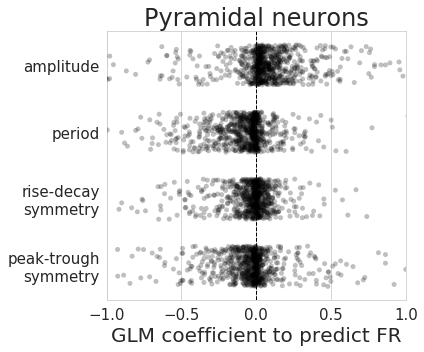

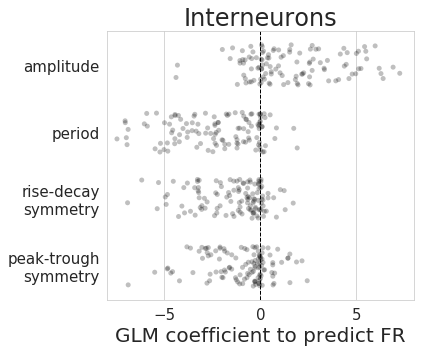

In [6]:
# All features
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
feat_names = {'volt_amp': 'amplitude', 'period': 'period',
              'time_rdsym': 'rise-decay\nsymmetry', 'time_ptsym': 'peak-trough\nsymmetry'}

# Prep df for plotting
df_plt = df_neus[['type']+['glm_burst_fr_coef_'+feat for feat in feats]].set_index('type').stack().reset_index().rename(
         columns={'level_1': 'feature', 0: 'glm_coef'}).replace(
         {'glm_burst_fr_coef_'+k:feat_names[k] for k in feats})
df_plt_p = df_plt[df_plt['type']=='p']
df_plt_i = df_plt[df_plt['type']=='i']

# Plot distribution of coefs for PY
plt.figure(figsize=(6, 5))
plt.plot([0,0], [-10,10], 'k--')
sns.stripplot(x='glm_coef', y='feature', data=df_plt_p,
              color='k', alpha=.25, jitter=.3)
plt.xlabel('GLM coefficient to predict FR')
plt.ylim((3.5, -0.5))
plt.ylabel('')
plt.xlim((-1, 1))
plt.title('Pyramidal neurons')

plt.tight_layout()
plt.savefig('figs/5/A.png')

# Plot distribution of coefs for IN
plt.figure(figsize=(6, 5))
plt.plot([0,0], [-10,10], 'k--')
sns.stripplot(x='glm_coef', y='feature', data=df_plt_i,
              color='k', alpha=.25, jitter=.3)
plt.xlabel('GLM coefficient to predict FR')
plt.ylim((3.5, -0.5))
plt.ylabel('')
plt.xlim((-8, 8))
plt.title('Interneurons')

plt.tight_layout()
plt.savefig('figs/5/B.png')

### Significance in coefficient skewness

In [7]:
for typ in ['p', 'i']:
    df_temp = df_neus[df_neus['type']==typ]
    print('N = ', len(df_temp))
    for feat in feats:
        W, p = stats.wilcoxon(df_temp['glm_burst_fr_coef_{:s}'.format(feat)])
        print('{:10s} {:s}, W = {:.0f}, p = {:.0E}, mean coef = {:5.2f}'.format(
            feat, typ, W, p, df_temp['glm_burst_fr_coef_{:s}'.format(feat)].mean()))

N =  760
volt_amp   p, W = 74416, p = 5E-31, mean coef =  0.06
period     p, W = 66820, p = 9E-38, mean coef = -0.08
time_rdsym p, W = 117298, p = 7E-06, mean coef = -0.04
time_ptsym p, W = 97066, p = 4E-15, mean coef = -0.04
N =  119
volt_amp   i, W = 1072, p = 3E-11, mean coef =  2.04
period     i, W = 337, p = 1E-17, mean coef = -2.42
time_rdsym i, W = 613, p = 4E-15, mean coef = -1.41
time_ptsym i, W = 1366, p = 5E-09, mean coef = -0.96


### R^2 of models

p Mean R^2: 0.029
i Mean R^2: 0.209


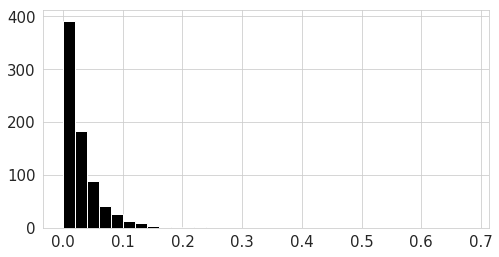

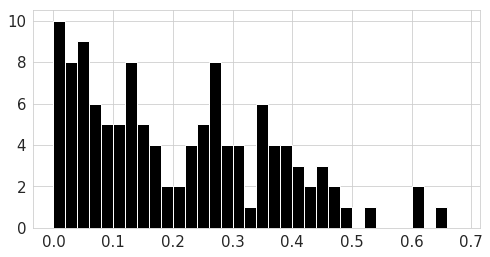

In [8]:
for typ in ['p', 'i']:
    plt.figure(figsize=(8,4))
    df_plt = df_neus[df_neus['type']==typ]
    plt.hist(df_plt['glm_burst_fr_r2'], bins=np.arange(0,.7, .02), color='k')
    print('{:s} Mean R^2: {:.3f}'.format(typ, df_plt['glm_burst_fr_r2'].mean()))


### Firing rate explains much variance in the variance explained by the cycle features model

r = 0.74


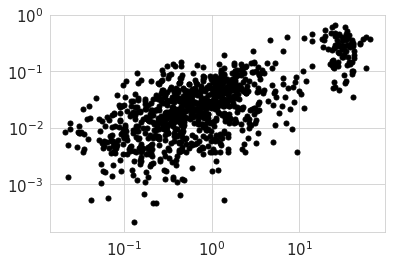

In [9]:
plt.loglog(df_neus['fr_burst0'], df_neus['glm_burst_fr_r2'], 'k.')
r, p = stats.pearsonr(df_neus['fr_burst0'], df_neus['glm_burst_fr_r2'])
print('r = {:.2f}'.format(r))

### Add speed to model: Significance in coefficient skewness

In [10]:
for typ in ['p', 'i']:
    df_temp = df_neus[df_neus['type']==typ]
    print(len(df_temp))
    for feat in feats:
        W, p = stats.wilcoxon(df_temp['glm_speed_fr_coef_{:s}'.format(feat)])
        print('{:10s} {:s}, W = {:.0f}, p = {:.0E}, mean coef = {:5.2f}'.format(
            feat, typ, W, p, df_temp['glm_speed_fr_coef_{:s}'.format(feat)].mean()))

760
volt_amp   p, W = 7648, p = 3E-113, mean coef =  0.07
period     p, W = 8652, p = 1E-111, mean coef = -0.07
time_rdsym p, W = 19523, p = 8E-95, mean coef = -0.02
time_ptsym p, W = 14535, p = 2E-102, mean coef = -0.02
119
volt_amp   i, W = 19, p = 5E-21, mean coef =  2.03
period     i, W = 26, p = 6E-21, mean coef = -2.24
time_rdsym i, W = 50, p = 1E-20, mean coef = -1.54
time_ptsym i, W = 90, p = 3E-20, mean coef = -1.01


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/stats/morestats.py:2391: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/stats/morestats.py:2392: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


# C-D. FR-rdsym corr is more apparent when average within burst
Example neuron

In [11]:
# Determine recording of interest
df_temp = df_neus.merge(df_shanks[['rat','sess','sh','Fs']], on=['rat','sess','sh'])
idx_oi = df_temp.sort_values(by='corr_burst_across_fr_time_rdsym_r').index[1]
row = df_temp.loc[idx_oi]

# Load spikes and shape of interest
path_shape = config_dict['mat_path'] + row['rat'] + \
    '/' + row['sess'] + '/' + str(row['sh']) + '/cycle_by_cycle_shape.csv'
df_shape = pd.read_csv(path_shape, index_col=0)

# Determine burst numbers and durations
df_shape_cycles = df_shape[df_shape['is_burst0'] == 1]
groups = []
for k, g in groupby(enumerate(df_shape_cycles.index), lambda x:x[0]-x[1]):
    groups.append(list(map(itemgetter(1), g)))
burst_lens = [len(x) for x in groups]
burst_lens_cycle = [burst_lens[burst_i] for burst_i in range(len(groups)) for cycle_i in groups[burst_i]]
burst_nums_cycle = [burst_i for burst_i in range(len(groups)) for cycle_i in groups[burst_i]]
df_shape_cycles['burst_number'] = burst_nums_cycle
df_shape_cycles['burst_len'] = burst_lens_cycle
df_shape = df_shape.merge(df_shape_cycles[['sample_trough', 'burst_number', 'burst_len']],
                          on='sample_trough', how='left')

# Load spikes per cycle
path_spikes = config_dict['mat_path'] + row['rat'] + \
    '/' + row['sess'] + '/' + str(row['sh']) + '/spikes_per_cycle.json'
df_spikes = pd.read_json(path_spikes)
df_spikes['spikes'] = df_spikes[row['clu']]

# Get firing rate in each cycle
df_shapespk = df_shape.merge(df_spikes[['spikes']], left_index=True, right_index=True).reset_index(drop=True)
df_shapespk = df_shapespk[df_shapespk['is_burst0'] == 1].reset_index(drop=True)
df_shapespk['Nspikes'] = df_shapespk['spikes'].str.len()
df_shapespk['fr'] = df_shapespk['Nspikes'] / (df_shapespk['period'] / row['Fs'])

# Average firing rate and rdsym for each burst
df_bursts = df_shapespk.groupby('burst_number')[['time_rdsym', 'fr']].mean()

across cycles: r = -0.17, p = 9.747610E-20
across bursts: r = -0.49, p = 7.561214E-14


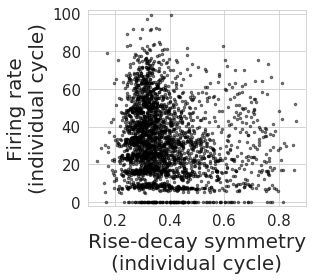

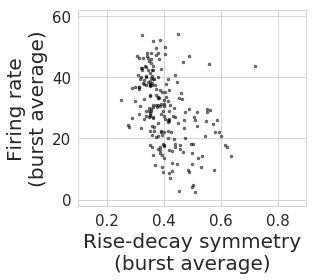

In [12]:
# Plot correlation between FR and rdsym for cycles and bursts
r, p = stats.spearmanr(df_shapespk['time_rdsym'], df_shapespk['fr'])
print('across cycles: r = {:.2f}, p = {:0E}'.format(r, p))
r, p = stats.spearmanr(df_bursts['time_rdsym'], df_bursts['fr'])
print('across bursts: r = {:.2f}, p = {:0E}'.format(r, p))

plt.figure(figsize=(4.5, 4))
plt.plot(df_shapespk['time_rdsym'], df_shapespk['fr'],
         'k.', ms=5, alpha=.5)
plt.ylabel('Firing rate\n(individual cycle)')
plt.xlabel('Rise-decay symmetry\n(individual cycle)')
plt.xlim((.1, .9))
plt.ylim((-2, 102))
plt.tight_layout()
plt.savefig('figs/5/C.png')

plt.figure(figsize=(4.5, 4))
plt.plot(df_bursts['time_rdsym'], df_bursts['fr'],
         'k.', ms=5, alpha=.5)
plt.ylabel('Firing rate\n(burst average)')
plt.xlabel('Rise-decay symmetry\n(burst average)')
plt.xlim((.1, .9))
plt.ylim((-2, 62))
plt.tight_layout()
plt.savefig('figs/5/D.png')


# E-F. Neuron's preferred phase ~ (FR ~ symmetry)

In [13]:
# Print circular correlation
from util import circ_corrcc

for feat in ['time_rdsym', 'time_ptsym']:
    df_temp = df_neus.copy()
    df_temp.dropna(subset=['sfc_phase_cycles_2pi'], inplace=True)
    r, p = circ_corrcc(df_temp['sfc_phase_cycles_2pi'],
                        df_temp['corr_burst_across_fr_'+feat+'_r'])
    print('{:10s}, rho = {:.2f}, p = {:.1E}'.format(feat, r, p))

time_rdsym, rho = 0.20, p = 1.6E-08
time_ptsym, rho = 0.22, p = 4.9E-10


#### Test for rank correlation between FR~rdsym and the difference between its phase and the middle of the rise (-pi/2)

-0.1421691378435681 1.6721817270163764e-05


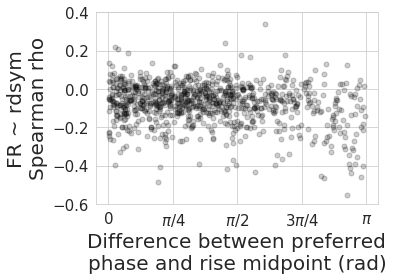

In [14]:
def compute_phadiff_midrise(pha):
    if pha < (np.pi / 2):
        return np.pi / 2 + pha
    else:
        return np.abs((3 * np.pi / 2) - pha)

df_neus['sfc_phase_from_midrise'] =df_neus['sfc_phase_cycles_2pi'].apply(compute_phadiff_midrise)

df_plt = df_neus.dropna(subset=['sfc_phase_from_midrise'])
r, p = stats.spearmanr(df_plt['sfc_phase_from_midrise'],
                       df_plt['corr_burst_across_fr_time_rdsym_r'])
print(r, p)

plt.figure(figsize=(5.5, 4))
plt.plot(df_plt['sfc_phase_from_midrise'],
         df_plt['corr_burst_across_fr_time_rdsym_r'], 'k.', alpha=.2)
plt.xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi],
           ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
plt.xlabel('Difference between preferred\nphase and rise midpoint (rad)')
plt.ylabel('FR ~ rdsym\nSpearman rho')
plt.ylim((-.6, .4))
plt.tight_layout()
plt.savefig('figs/5/E.png')

#### Test for rank correlation between FR~ptsym and the difference between its phase and the peak (0)

-0.1255068204737266 0.00014712096048699152


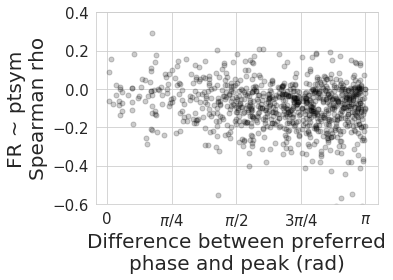

In [15]:
df_neus['sfc_phase_from_peak'] = np.pi - np.abs(df_neus['sfc_phase_cycles_2pi'] - np.pi)
df_plt = df_neus.dropna(subset=['sfc_phase_from_peak'])
r, p = stats.spearmanr(df_plt['sfc_phase_from_peak'],
                       df_plt['corr_burst_across_fr_time_ptsym_r'])
print(r, p)

plt.figure(figsize=(5.5, 4))
plt.plot(df_plt['sfc_phase_from_peak'],
         df_plt['corr_burst_across_fr_time_ptsym_r'], 'k.', alpha=.2)
plt.xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi],
           ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
plt.xlabel('Difference between preferred\nphase and peak (rad)')
plt.ylabel('FR ~ ptsym\nSpearman rho')
plt.ylim((-.6, .4))
plt.tight_layout()
plt.savefig('figs/5/F.png')

#### Run analysis separately for PY and IN neurons

In [16]:
for typ in ['p', 'i']:
    df_neus['sfc_phase_from_peak'] = np.pi - np.abs(df_neus['sfc_phase_cycles_2pi'] - np.pi)
    df_plt = df_neus.dropna(subset=['sfc_phase_from_peak'])
    df_plt = df_plt[df_plt['type']==typ]
    r, p = stats.spearmanr(df_plt['sfc_phase_from_peak'],
                           df_plt['corr_burst_across_fr_time_ptsym_r'])
    print('FR ~ ptsym, neu {:s}, r = {:.2f}, p = {:.3f}'.format(typ, r, p))
    
    df_plt = df_neus.dropna(subset=['sfc_phase_from_midrise'])
    df_plt = df_plt[df_plt['type'] == typ]
    r, p = stats.spearmanr(df_plt['sfc_phase_from_midrise'],
                           df_plt['corr_burst_across_fr_time_rdsym_r'])
    print('FR ~ rdsym, neu {:s}, r = {:.2f}, p = {:.3f}'.format(typ, r, p))

FR ~ ptsym, neu p, r = -0.10, p = 0.008
FR ~ rdsym, neu p, r = -0.08, p = 0.036
FR ~ ptsym, neu i, r = -0.26, p = 0.004
FR ~ rdsym, neu i, r = -0.22, p = 0.016


#### Run analysis with minimum SFC

In [17]:
df_plt['sfc_magnitude_cycles'].describe()

count    119.000000
mean       0.279657
std        0.111497
min        0.037540
25%        0.196426
50%        0.274616
75%        0.357759
max        0.575211
Name: sfc_magnitude_cycles, dtype: float64

In [18]:
for min_sfc in [.1, .2, .3]:
    df_plt = df_neus.dropna(subset=['sfc_phase_from_midrise'])
    df_plt = df_plt[df_plt['sfc_magnitude_cycles'] > min_sfc]
    r, p = stats.spearmanr(df_plt['sfc_phase_from_midrise'],
                           df_plt['corr_burst_across_fr_time_rdsym_r'])
    print('FR ~ rdsym, min sfc = {:.1f}, r = {:.2f}, p = {:.1E}'.format(min_sfc, r, p))

    df_plt = df_neus.dropna(subset=['sfc_phase_from_peak'])
    df_plt = df_plt[df_plt['sfc_magnitude_cycles'] > min_sfc]
    r, p = stats.spearmanr(df_plt['sfc_phase_from_peak'],
                           df_plt['corr_burst_across_fr_time_ptsym_r'])
    print('FR ~ ptsym, min sfc = {:.1f}, r = {:.2f}, p = {:.1E}'.format(min_sfc, r, p))


FR ~ rdsym, min sfc = 0.1, r = -0.18, p = 9.2E-07
FR ~ ptsym, min sfc = 0.1, r = -0.15, p = 6.0E-05
FR ~ rdsym, min sfc = 0.2, r = -0.24, p = 1.5E-06
FR ~ ptsym, min sfc = 0.2, r = -0.19, p = 1.9E-04
FR ~ rdsym, min sfc = 0.3, r = -0.38, p = 8.8E-07
FR ~ ptsym, min sfc = 0.3, r = -0.18, p = 2.2E-02
